# Final Project - Reinforcements Learning

<br>
Project of Tomer Juster and Daniel Itkes as part of a course in intro to reinforcement learning

<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!pip install stable-baselines3[extra]
!git clone https://github.com/avivg7/sokoban-so.git
!git clone https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission.git
!unzip /content/sokoban-so/Compress.zip


# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
import torch.nn.functional as F
from itertools import count
from stable_baselines3 import PPO, DQN
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image, display

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read();
  b64 = base64.b64encode(video);
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode());

  return IPython.display.HTML(tag);
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [ ]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function - given an environment it will return the indexes position and boxes locations

In [ ]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

# EX1 - FIX SCENARIO - PUSH & PULL - ONE BOX - DQN
---


In [ ]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

##Utils

In [ ]:
def conv2d_size_out(size, kernel_size=5, stride=2):
    return (size - (kernel_size - 1) - 1) // stride + 1

h, w, c = sok.observation_space.shape

# Capture the initial configuration for fixed environment (Ex1) and reset env method to use after every episode
initial_room_state = sok.room_state.copy()
initial_room_fixed = sok.room_fixed.copy()
initial_player_position = sok.player_position.copy()
initial_box_position = find_box_location(sok)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def reset_to_initial(env, initial_room_state, initial_room_fixed, initial_player_position, initial_box_position):
    env.room_state = initial_room_state.copy()
    env.room_fixed = initial_room_fixed.copy()
    env.player_position = initial_player_position.copy()

    env.room_state[env.room_state == 4] = 2
    env.room_state[initial_box_position] = 4

    return env.render(mode='rgb_array')


def save_checkpoint(filename, policy_model):
    checkpoint = {
        'policy_model_state_dict': policy_model.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(filename, policy_model):
    checkpoint = torch.load(filename)
    policy_model.load_state_dict(checkpoint['policy_model_state_dict'])
    # target_model.load_state_dict(policy_model.state_dict())
    # target_model.eval()


def plot_model_performance(mean_rewards, mean_lengths):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(mean_rewards)
  plt.title('Mean Episodic Reward')
  plt.xlabel('Episode')
  plt.ylabel('Mean Reward')

  plt.subplot(1, 2, 2)
  plt.plot(mean_lengths)
  plt.title('Mean Episodic Length')
  plt.xlabel('Episode')
  plt.ylabel('Mean Length')

  plt.show()

def video_test(env, model, fixed=False):
  # Evaluation video
  if fixed:
    reset_to_initial(env, initial_room_state, initial_room_fixed, initial_player_position, initial_box_position)
  else:
    env.reset()
  start_time = time.time()
  done = False
  iter = 0
  video_filename = 'dqn_evaluation.mp4'
  initial_frame = env.render(mode='rgb_array')

  with imageio.get_writer(video_filename, fps=10) as video:
      video.append_data(initial_frame)  # Add the initial frame to the video
      state = torch.tensor(env.render(mode='rgb_array').transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)
      while (iter < 10) or not done:
          time_passed = int(time.time() - start_time)
          if done or time_passed > 3:
              break
          iter += 1
          action = model(state).max(1)[1].view(1, 1)
          observation, reward, done, _ = env.step(action.item())
          video.append_data(env.render(mode='rgb_array'))

          # Update the state variable with the new observation
          state = torch.tensor(observation.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)

  return video_filename

##DQN Model

In [ ]:
# Calculate the dimensions after passing through all the convolutional layers
convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
linear_input_size = convw * convh * 32  # 32 is the output channel size of the last conv layer
n_actions = sok.action_space.n

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## Train and Evaluate Model
The training process is described in the following notebook: <br>
https://colab.research.google.com/drive/1RqKxb4JlEDaCUOkBDFe1raIhMfShQI6c?usp=sharing

We will display the results of the trained models.

In [ ]:
mid_train_model = DQN(h, w, n_actions).to(device)
end_train_model = DQN(h, w, n_actions).to(device)

load_checkpoint('Intro_to_Reinforcement-Learning-Final_Submission/Ex1/models/DQN-checkpoint-v1-ep50', mid_train_model)
load_checkpoint('Intro_to_Reinforcement-Learning-Final_Submission/Ex1/models/DQN-checkpoint-v1-ep100', end_train_model)

In [ ]:
def evaluate(env, policy_net, num_episodes, fixed=False):

  mean_reward = 0.0
  mean_length = 0.0
  num_solved = 0
  mean_rewards = []
  mean_lengths = []

  for _ in tqdm(range(num_episodes)):
      if fixed:
        state_array = reset_to_initial(env, initial_room_state, initial_room_fixed, initial_player_position, initial_box_position)
      else:
        state_array = env.reset()

      state = torch.tensor(state_array.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)
      done = False
      episode_reward = 0.0
      episode_length = 0
      iter = 0
      while not done and iter < 500:
          iter += 1

          action = policy_net(state).max(1)[1].view(1, 1)

          next_state, reward, done, _ = env.step(action.item())

          next_state = torch.tensor(next_state.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)

          state = next_state

          episode_reward += reward
          episode_length += 1

      mean_reward += episode_reward
      mean_length += episode_length

      if done and episode_length < 500 - 1:
          num_solved += 1

      mean_rewards.append(episode_reward)
      mean_lengths.append(episode_length)

  mean_reward /= num_episodes
  mean_length /= num_episodes

  print()
  print(f"Mean reward over {num_episodes} episodes: {mean_reward}")
  print(f"Mean length per episode: {mean_length}")
  print(f"Number of environments solved: {num_solved}")

## EX1 Evaluation and Video Test - Middle of Training

In [ ]:
print("=" * 20 + "Evaluating Middle of Training Model" + "=" * 20)
print()
evaluate(sok, mid_train_model, 100, fixed=True)

print("=" * 20 + "Video Test End of Training Model" + "=" * 20)
print()
embed_mp4(video_test(sok, mid_train_model, fixed=True))

====================Evaluating Middle of Training Model====================



100%|██████████| 100/100 [02:56<00:00,  1.76s/it]



Mean reward over 100 episodes: -50.00000000000036
Mean length per episode: 500.0
Number of environments solved: 0
====================Video Test End of Training Model====================



/usr/local/lib/python3.10/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


## EX1 Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model" + "=" * 20)
print()
evaluate(sok, end_train_model, 100, fixed=True)

print("=" * 20 + "Video Test End of Training Model" + "=" * 20)
print()
embed_mp4(video_test(sok, end_train_model, fixed=True))

====================Evaluating End of Training Model====================



100%|██████████| 100/100 [00:03<00:00, 30.42it/s]



Mean reward over 100 episodes: 9.110000000000015
Mean length per episode: 9.0
Number of environments solved: 100
====================Video Test End of Training Model====================



# EX2 - PUSH & PULL - ONE BOX
---

In [ ]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

##Experiment 1: DQN Version 1
---

### Train and Evaluate Model
The training process is described in the following notebook, and is identical to Ex1 only with random initialization of the environment: <br>
https://colab.research.google.com/drive/1drsQAjDsobYrKx7j_E_dH6mk04NB_WIN#scrollTo=chMCyINF0IXe

We will display the results of the trained models.

In [ ]:
mid_train_model_v1 = DQN(h, w, n_actions).to(device)
end_train_model_v1 = DQN(h, w, n_actions).to(device)

load_checkpoint("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 1/models/DQN-checkpoint-v1-ep150.zip", mid_train_model_v1)
load_checkpoint("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 1/models/DQN-checkpoint-v1-ep300.zip", end_train_model_v1)

### Model Evaluation and Video Test - Middle of Training


In [ ]:
print("=" * 20 + "Evaluating Middle of Training Model v1" + "=" * 20)
print()
evaluate(sok_2, mid_train_model_v1, 100)

print("=" * 20 + "Video Test Middle of Training Model v1" + "=" * 20)
print()
embed_mp4(video_test(sok_2, mid_train_model_v1))

====================Evaluating Middle of Training Model v1====================



100%|██████████| 100/100 [02:02<00:00,  1.22s/it]



Mean reward over 100 episodes: -32.98300000000033
Mean length per episode: 360.63
Number of environments solved: 28
====================Video Test Middle of Training Model v1====================



### Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model v1" + "=" * 20)
print()
evaluate(sok_2, end_train_model_v1, 100)

print("=" * 20 + "Video Test End of Training Model v1" + "=" * 20)
print()
embed_mp4(video_test(sok_2, end_train_model_v1))

====================Evaluating End of Training Model v1====================



100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


Mean reward over 100 episodes: -37.23500000000036
Mean length per episode: 395.45
Number of environments solved: 21
====================Video Test End of Training Model v1====================



##Experiment 2: DQN Version 2

### Train and Evaluate Model
The training process is described in the following notebook, the main change from version 1 is the reward shaping mechanism: <br>
https://colab.research.google.com/drive/19m1RLKuYqpEiZmt1deNZ_UEGDKcLxB_d?usp=sharing

We will display the results of the trained models.

---

In [ ]:
mid_train_model_v2 = DQN(h, w, n_actions).to(device)
end_train_model_v2 = DQN(h, w, n_actions).to(device)

load_checkpoint('/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 2/models/DQN-checkpoint-v2-ep150', mid_train_model_v2)
load_checkpoint('/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 2/models/DQN-checkpoint-v2-ep300', end_train_model_v2)

### Model Evaluation and Video Test - Middle of Training


In [ ]:
print("=" * 20 + "Evaluating Middle of Training Model v2" + "=" * 20)
print()
evaluate(sok_2, mid_train_model_v2, 100)

print("=" * 20 + "Video Test Middle of Training Model v2" + "=" * 20)
print()
embed_mp4(video_test(sok_2, mid_train_model_v2))

====================Evaluating Middle of Training Model v2====================



100%|██████████| 100/100 [02:09<00:00,  1.29s/it]



Mean reward over 100 episodes: -35.416000000000345
Mean length per episode: 380.56
Number of environments solved: 24
====================Video Test Middle of Training Model v2====================



### Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model v2" + "=" * 20)
print()
evaluate(sok_2, end_train_model_v2, 100)

print("=" * 20 + "Video Test End of Training Model v2" + "=" * 20)
print()
embed_mp4(video_test(sok_2, end_train_model_v2))

====================Evaluating End of Training Model v2====================



100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Mean reward over 100 episodes: -29.943000000000303
Mean length per episode: 335.73
Number of environments solved: 33
====================Video Test End of Training Model v2====================



## Experiment 3: Evaluating Different "Stable Baselines3" Models

### Custom Environment
We define a custom environment to control the training of the "Stable Baselines3" models.

In [ ]:
class CustomSokoban1(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7,7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)

    def reset(self):
        obs = super().reset()
        return obs

    def step(self, action):
        return super().step(action)

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)

### Train and Evaluate Model
We are training our "Stable Baselines3" models locally. We are running the following python script that can be found here: <br>

https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission/tree/main/Ex2/SB3_different_model_performance <br>

In this experiment we will train a couple of models just to get the feeling for the framework, and determine with which algorithm we should proceed.

In [ ]:
# =============== Python Script ===============
#
# from stable_baselines3 import PPO, DQN, A2C
# from custom_env import CustomSokoban1
# import argparse
# import os

# MODEL_DIR = "models/"
# LOG_DIR = "logs"

# if not os.path.exists(LOG_DIR):
#         os.makedirs(LOG_DIR)

# env = CustomSokoban1()
# env.reset()

# models = {"PPO": PPO("MlpPolicy", env, device='cuda', verbose=1, tensorboard_log=LOG_DIR),
#           "A2C": A2C("MlpPolicy", env, device='cuda', verbose=1, tensorboard_log=LOG_DIR),
#           "DQN": DQN("MlpPolicy", env, device='cuda', verbose=1, tensorboard_log=LOG_DIR, buffer_size=10000)}

# def main(model_type, model_name, model_location=None, load_model=False, time_steps=10000, num_iterations=5):

#     if load_model:
#         model = models[model_type].load(model_location)
#     else:
#         model = models[model_type]

#     model_path = MODEL_DIR + model_name


#     if not os.path.exists(model_path):
#         os.makedirs(model_path)

#     iter_num = number_of_items = len(os.listdir(model_path))

#     for i in range(num_iterations):
#         iter_num += 1
#         model.learn(total_timesteps=time_steps, reset_num_timesteps=False, tb_log_name=model_name)
#         model.save(f"{model_path}/{time_steps*iter_num}")

# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description="Train a reinforcement learning model.")
#     parser.add_argument("model_type", type=str, help="Model type (e.g., 'PPO')")
#     parser.add_argument("model_name", type=str, help="Name of the model")
#     parser.add_argument("--model_location", type=str, help="Location of the model to load", default=None)
#     parser.add_argument("--load_model", type=bool, help="Whether to load the model", default=False)
#     parser.add_argument("--time_steps", type=int, help="Number of time steps", default=10000)
#     parser.add_argument("--num_iterations", type=int, help="Number of iterations", default=5)

#     args = parser.parse_args()
#     main(args.model_type, args.model_name, args.model_location, args.load_model, args.time_steps, args.num_iterations)

In [ ]:
from IPython.display import Image, display

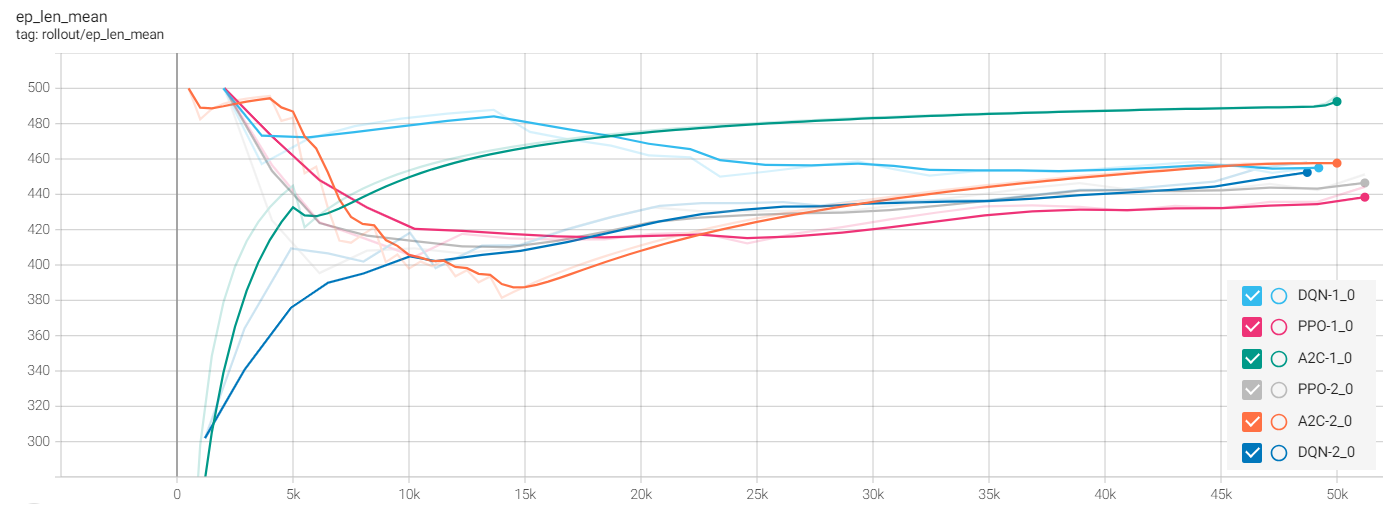

In [ ]:
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 3/Training_logs.png"))

##Experiment 4: PPO/DQN Without Reward Shaping

### Train and Evaluate Model
We have used the same settings as in Experiment 3, with the original environment.

In [ ]:
from stable_baselines3 import DQN,PPO

In [ ]:
env = CustomSokoban1();

DQN_v3_1 =  DQN.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 4/models/DQN-v3-v1.zip");
PPO_v3_1 = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 4/models/PPO-v3-v1.zip");

DQN_v3_1.set_env(env);
PPO_v3_1.set_env(env);

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


### During Training Logs

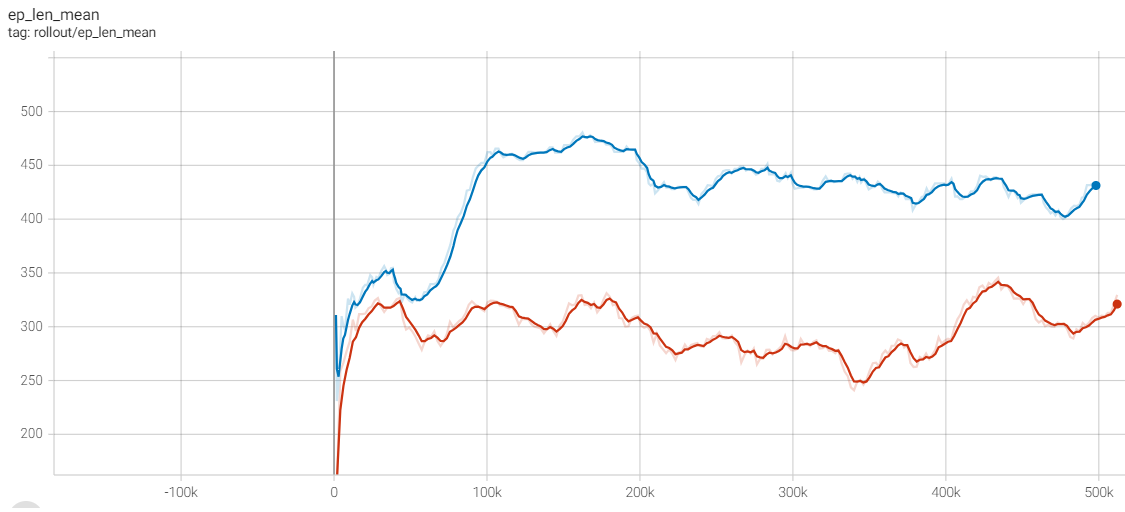

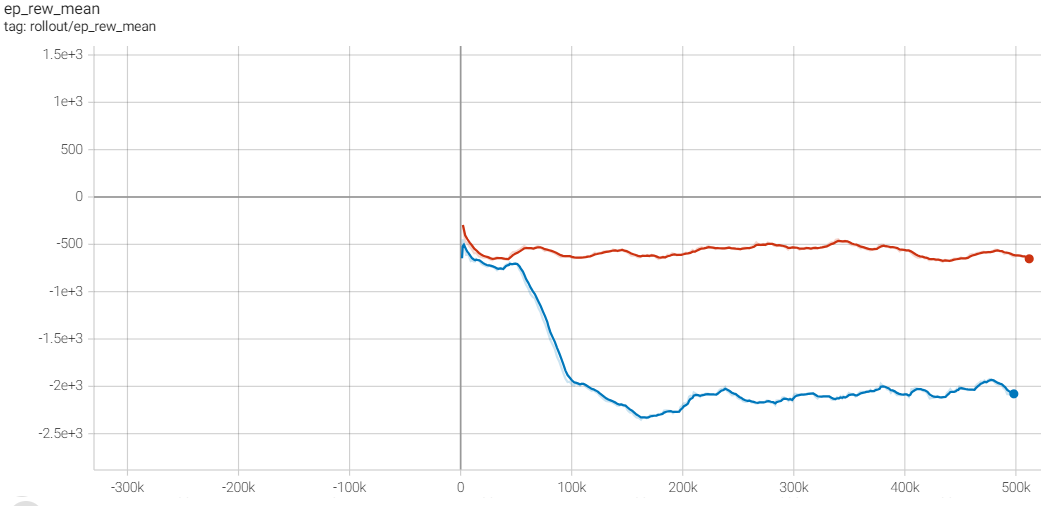

In [ ]:
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 4/E4-EML.png"))
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 4/E4-EMR.png"))

In [ ]:
def evaluate(env, model, n_episodes=100):

  # Evaluate the model
  mean_reward = 0.0
  mean_length = 0.0
  num_solved = 0
  n_episodes = 100

  for _ in tqdm(range(n_episodes)):
      obs = env.reset()
      done = False
      episode_reward = 0.0
      episode_length = 0
      while not done:
          action, _ = model.predict(obs)
          obs, reward, done, _ = env.step(action.item())
          episode_reward += reward
          episode_length += 1

      mean_reward += episode_reward
      mean_length += episode_length

      if done and episode_length < 500:
          num_solved += 1

  mean_reward /= n_episodes
  mean_length /= n_episodes

  print(f"Mean reward over {n_episodes} episodes: {mean_reward}")
  print(f"Mean length per episode: {mean_length}")
  print(f"Number of environments solved: {num_solved}")

def video_test2(env, model):
  start_time = time.time()
  done = False
  iter = 0
  rewards = 0
  video_filename = 'imageio.mp4'
  observation = env.reset()

  with imageio.get_writer(video_filename, fps=10) as video:
    while (iter < 100) or not done:
      time_passed = int(time.time() - start_time)
      if done or time_passed > 3:
        break
      iter +=1
      action, _states = model.predict(observation)
      observation, reward, done, info = env.step(int(action))
      rewards += reward
      video.append_data(env.render())
  return video_filename

### DQN Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model DQN-v3-1" + "=" * 20)
print()
evaluate(env, DQN_v3_1, 100)

print("=" * 20 + "Video Test End of Training Model DQN-v3-1" + "=" * 20)
print()
embed_mp4(video_test2(env, DQN_v3_1))

====================Evaluating End of Training Model DQN-v3-1====================



100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


Mean reward over 100 episodes: -47.27300000000037
Mean length per episode: 479.33
Number of environments solved: 6
====================Video Test End of Training Model DQN-v3-1====================



### PPO Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model PPO-v3-1" + "=" * 20)
print()
evaluate(env, PPO_v3_1, 100)

print("=" * 20 + "Video Test End of Training Model PPO-v3-1" + "=" * 20)
print()
embed_mp4(video_test2(env, PPO_v3_1))

====================Evaluating End of Training Model PPO-v3-1====================



100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Mean reward over 100 episodes: -28.796000000000276
Mean length per episode: 333.06
Number of environments solved: 41
====================Video Test End of Training Model PPO-v3-1====================



## Experiment 5: PPO with different Reward Shapings
---

### Custom Environments
In this experiment we will use the custom environment and encorporate three different reward shaping mechanisms, recall that the original environment modified the following: <br>
1. +/- Big reward based on distance of box from target.
2. +/- Small reward based on distance of box from agent.
3. -Small reward based on unchanged room state.

We will make the following modification to handle the tendency of the agent to go back and forward, as explained in the report: <br>
The first environment will penalize/reward the agent based on whether it pushed the box if it is adjacent to the it. <br>
The second environment will penalize/reward the agent for every step to encourage faster convergence. <br>
The third environment will penalize/reward the agent if the cell it is in was already visited in the last X steps (we choose x = 4).


In [ ]:
class CustomSokoban2(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)

    def reset(self):
        obs = super().reset()

        self.current_room_state = self.room_state.copy()
        self.distances = self.get_distances(self.current_room_state)

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        self.next_room_state = self.room_state.copy()

        if not done:
            reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state, distances_to_target):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.1

        current_box_position, current_monster_position = self.get_positions(current_room_state, distances_to_target)
        next_box_position, next_monster_position = self.get_positions(next_room_state, distances_to_target)

        # Calculate distances
        current_b2m = self.get_box_to_monster_distance(current_box_position, current_monster_position)
        next_b2m = self.get_box_to_monster_distance(next_box_position, next_monster_position)
        current_b2t = self.get_box_to_target_distance(current_box_position, distances_to_target)
        next_b2t = self.get_box_to_target_distance(next_box_position, distances_to_target)

        # Reward agent based on if box moved closer to target
        reward_b2t = 0.5 if next_b2t < current_b2t else (-0.5 if next_b2t > current_b2t else 0.0)

        # Reward agent based on if agent moved closer to box
        reward_b2m = 0.1 if (next_b2m < current_b2m and next_b2m >= 2) else (-0.1 if (next_b2m > current_b2m and next_b2m >= 2) else 0.0)

        # Reward agent based on if agent push box if it is adjacent to it
        reward_adj_push = 2.0 if current_b2m < 2 and next_b2m < 2 and current_b2t == next_b2t else 0.0

        return reward_b2t + reward_b2m + reward_adj_push


    def get_positions(self, room_state, distances):
        box_position = tuple(np.argwhere(room_state == 4).ravel())
        monster_position = tuple(np.argwhere(room_state == 5).ravel())

        return box_position, monster_position


    def get_box_to_monster_distance(self, box_position, monster_position):
        return np.sum((np.array(monster_position) - np.array(box_position))**2)


    def get_box_to_target_distance(self, box_position, distances_to_target):
        return distances_to_target[box_position]


    def get_distances(self, room_state):
        target = np.where(room_state == 2)
        if target[0].size == 0:
            return None

        target = (target[0][0], target[1][0])
        distances = np.full_like(room_state, -1, dtype=int)
        distances[target] = 0

        visited_cells = {target}
        cell_queue = deque([target])

        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        while cell_queue:
            cell_x, cell_y = cell_queue.popleft()
            distance = distances[cell_x][cell_y]

            for dx, dy in directions:
                next_cell_x, next_cell_y = cell_x + dx, cell_y + dy

                if (0 <= next_cell_x < room_state.shape[0]
                        and 0 <= next_cell_y < room_state.shape[1]
                        and room_state[next_cell_x][next_cell_y] != 0
                        and (next_cell_x, next_cell_y) not in visited_cells):
                    distances[next_cell_x][next_cell_y] = distance + 1
                    visited_cells.add((next_cell_x, next_cell_y))
                    cell_queue.append((next_cell_x, next_cell_y))

        return distances


In [ ]:
class CustomSokoban3(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)

    def reset(self):
        obs = super().reset()

        self.current_room_state = self.room_state.copy()
        self.distances = self.get_distances(self.current_room_state)

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        self.next_room_state = self.room_state.copy()

        if not done:
            reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state, distances_to_target):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.1

        current_box_position, current_monster_position = self.get_positions(current_room_state, distances_to_target)
        next_box_position, next_monster_position = self.get_positions(next_room_state, distances_to_target)

        # Calculate distances
        current_b2m = self.get_box_to_monster_distance(current_box_position, current_monster_position)
        next_b2m = self.get_box_to_monster_distance(next_box_position, next_monster_position)
        current_b2t = self.get_box_to_target_distance(current_box_position, distances_to_target)
        next_b2t = self.get_box_to_target_distance(next_box_position, distances_to_target)

        # Reward agent based on if box moved closer to target
        reward_b2t = 0.5 if next_b2t < current_b2t else (-0.5 if next_b2t > current_b2t else 0.0)

        # Reward agent based on if agent moved closer to box
        reward_b2m = 0.1 if (next_b2m < current_b2m and next_b2m >= 2) else (-0.1 if (next_b2m > current_b2m and next_b2m >= 2) else 0.0)

        # Penalize for every step
        return reward_b2t + reward_b2m - 1.0


    def get_positions(self, room_state, distances):
        box_position = tuple(np.argwhere(room_state == 4).ravel())
        monster_position = tuple(np.argwhere(room_state == 5).ravel())

        return box_position, monster_position


    def get_box_to_monster_distance(self, box_position, monster_position):
        return np.sum((np.array(monster_position) - np.array(box_position))**2)


    def get_box_to_target_distance(self, box_position, distances_to_target):
        return distances_to_target[box_position]


    def get_distances(self, room_state):
        target = np.where(room_state == 2)
        if target[0].size == 0:
            return None

        target = (target[0][0], target[1][0])
        distances = np.full_like(room_state, -1, dtype=int)
        distances[target] = 0

        visited_cells = {target}
        cell_queue = deque([target])

        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        while cell_queue:
            cell_x, cell_y = cell_queue.popleft()
            distance = distances[cell_x][cell_y]

            for dx, dy in directions:
                next_cell_x, next_cell_y = cell_x + dx, cell_y + dy

                if (0 <= next_cell_x < room_state.shape[0]
                        and 0 <= next_cell_y < room_state.shape[1]
                        and room_state[next_cell_x][next_cell_y] != 0
                        and (next_cell_x, next_cell_y) not in visited_cells):
                    distances[next_cell_x][next_cell_y] = distance + 1
                    visited_cells.add((next_cell_x, next_cell_y))
                    cell_queue.append((next_cell_x, next_cell_y))

        return distances


In [ ]:
class CustomSokoban4(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)
        self.position_memory = deque()

    def reset(self):
        obs = super().reset()
        self.position_memory = deque()
        self.current_room_state = self.room_state.copy()
        self.distances = self.get_distances(self.current_room_state)

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        self.next_room_state = self.room_state.copy()

        if not done:
            reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state, distances_to_target):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.1

        current_box_position, current_monster_position = self.get_positions(current_room_state, distances_to_target)
        next_box_position, next_monster_position = self.get_positions(next_room_state, distances_to_target)

        # Calculate distances
        current_b2m = self.get_box_to_monster_distance(current_box_position, current_monster_position)
        next_b2m = self.get_box_to_monster_distance(next_box_position, next_monster_position)
        current_b2t = self.get_box_to_target_distance(current_box_position, distances_to_target)
        next_b2t = self.get_box_to_target_distance(next_box_position, distances_to_target)

        # Reward agent based on if box moved closer to target
        reward_b2t = 5.0 if next_b2t < current_b2t else (-5.0 if next_b2t > current_b2t else 0.0)

        # Reward agent based on if agent moved closer to box
        reward_b2m = 1.0 if (next_b2m < current_b2m and next_b2m >= 2) else (-1.0 if (next_b2m > current_b2m and next_b2m >= 2) else 0.0)

        # Reward agent based on if agent push box if it is adjacent to it
        memory_reward = -1.0 if next_b2m in self.position_memory else 1.0

        # Add the mover's current position to the memory
        self.position_memory.append(next_b2m)
        if len(self.position_memory) > 4:
            self.position_memory.popleft()

        return reward_b2t + reward_b2m + memory_reward


    def get_positions(self, room_state, distances):
        box_position = tuple(np.argwhere(room_state == 4).ravel())
        monster_position = tuple(np.argwhere(room_state == 5).ravel())

        return box_position, monster_position


    def get_box_to_monster_distance(self, box_position, monster_position):
        return np.sum((np.array(monster_position) - np.array(box_position))**2)


    def get_box_to_target_distance(self, box_position, distances_to_target):
        return distances_to_target[box_position]


    def get_distances(self, room_state):
        target = np.where(room_state == 2)
        if target[0].size == 0:
            return None

        target = (target[0][0], target[1][0])
        distances = np.full_like(room_state, -1, dtype=int)
        distances[target] = 0

        visited_cells = {target}
        cell_queue = deque([target])

        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        while cell_queue:
            cell_x, cell_y = cell_queue.popleft()
            distance = distances[cell_x][cell_y]

            for dx, dy in directions:
                next_cell_x, next_cell_y = cell_x + dx, cell_y + dy

                if (0 <= next_cell_x < room_state.shape[0]
                        and 0 <= next_cell_y < room_state.shape[1]
                        and room_state[next_cell_x][next_cell_y] != 0
                        and (next_cell_x, next_cell_y) not in visited_cells):
                    distances[next_cell_x][next_cell_y] = distance + 1
                    visited_cells.add((next_cell_x, next_cell_y))
                    cell_queue.append((next_cell_x, next_cell_y))

        return distances

### Train and Evaluate Model
We will use the same setting as experiment 3, the full code can be found here:
https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission/tree/main/Ex2/Experiment%205

In [ ]:
env1 = CustomSokoban2();
env2 = CustomSokoban3()
env3 = CustomSokoban4()

PPO1_0_env1 = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 5/models/PPO1_0.zip");
PPO1_env2 = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 5/models/PPO1.zip");
PPO1_1_env3 = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 5/models/PPO1_1.zip");

PPO1_0_env1.set_env(env1);
PPO1_env2.set_env(env2);
PPO1_1_env3.set_env(env3);

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### During Training Logs

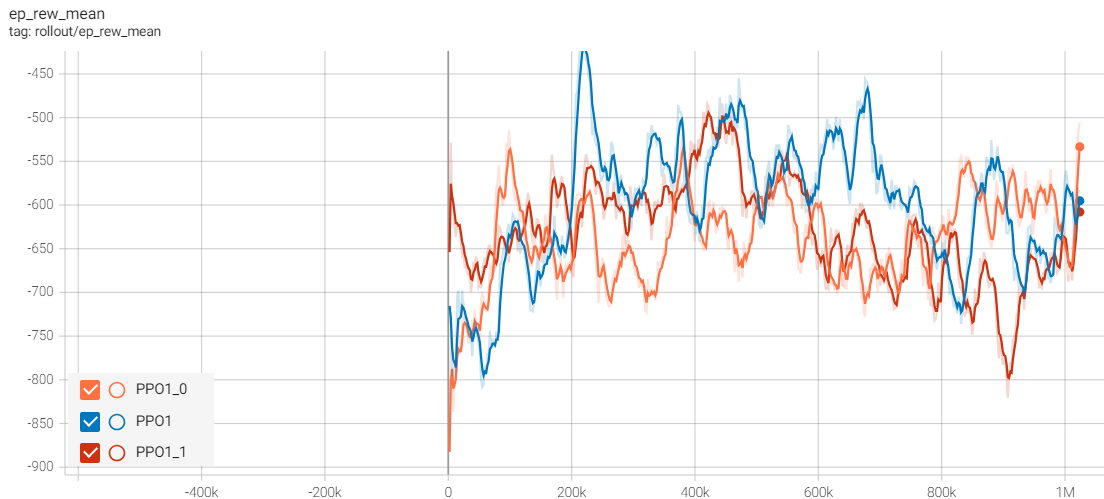

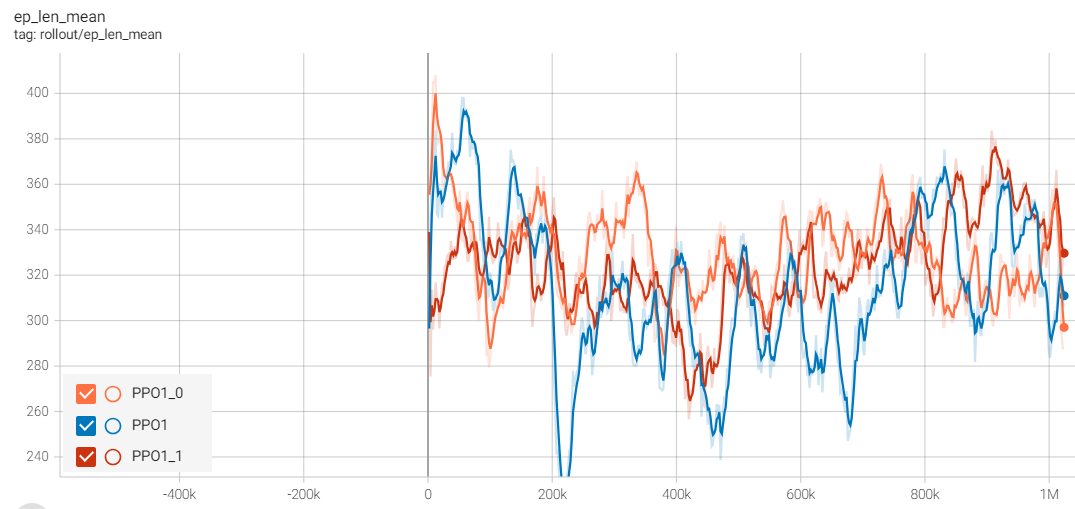

In [ ]:
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 5/E5 - ERM.png"))
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 5/E5-ELM.png"))

### PPO1_0 with Env1 Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model PPO1_0 with Env1" + "=" * 20)
print()
evaluate(env1, PPO1_0_env1, 100)

print("=" * 20 + "Video Test End of Training Model PPO1_0 with Env1" + "=" * 20)
print()
embed_mp4(video_test2(env1, PPO1_0_env1))

====================Evaluating End of Training Model PPO1_0 with Env1====================



100%|██████████| 100/100 [01:38<00:00,  1.02it/s]

Mean reward over 100 episodes: -37.16300000000026
Mean length per episode: 294.51
Number of environments solved: 45
====================Video Test End of Training Model PPO1_0 with Env1====================



### PPO1 with Env2 Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model PPO1 with Env2" + "=" * 20)
print()
evaluate(env2, PPO1_env2, 100)

print("=" * 20 + "Video Test End of Training Model PPO1 with Env2" + "=" * 20)
print()
embed_mp4(video_test2(env2, PPO1_env2))

====================Evaluating End of Training Model PPO1 with Env2====================



100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


Mean reward over 100 episodes: -266.9419999999984
Mean length per episode: 343.45
Number of environments solved: 34
====================Video Test End of Training Model PPO1 with Env2====================



### PPO1_1 with Env3 Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model PPO1_1 with Env3" + "=" * 20)
print()
evaluate(env3, PPO1_1_env3, 100)

print("=" * 20 + "Video Test End of Training Model PPO1_1 with Env3" + "=" * 20)
print()
embed_mp4(video_test2(env3, PPO1_1_env3))

====================Evaluating End of Training Model PPO1_1 with Env3====================



100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Mean reward over 100 episodes: -239.42899999999972
Mean length per episode: 366.69
Number of environments solved: 30
====================Video Test End of Training Model PPO1_1 with Env3====================



## Experiment 6: PPO CNN Policy
---

### Custom Environment

In [ ]:
class CustomSokoban5(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)
        obs = self.render()
        self.observation_space = spaces.Box(0, 255, obs.shape, obs.dtype)

    def reset(self):
        obs = super().reset()

        self.current_room_state = self.room_state.copy()
        self.distances = self.get_distances(self.current_room_state)

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        self.next_room_state = self.room_state.copy()

        if not done:
            reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state, distances_to_target):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.1

        current_box_position, current_monster_position = self.get_positions(current_room_state, distances_to_target)
        next_box_position, next_monster_position = self.get_positions(next_room_state, distances_to_target)

        # Calculate distances
        current_b2m = self.get_box_to_monster_distance(current_box_position, current_monster_position)
        next_b2m = self.get_box_to_monster_distance(next_box_position, next_monster_position)
        current_b2t = self.get_box_to_target_distance(current_box_position, distances_to_target)
        next_b2t = self.get_box_to_target_distance(next_box_position, distances_to_target)

        # Reward agent based on if box moved closer to target
        reward_b2t = 0.5 if next_b2t < current_b2t else (-0.5 if next_b2t > current_b2t else 0.0)

        # Reward agent based on if agent moved closer to box
        reward_b2m = 0.1 if (next_b2m < current_b2m and next_b2m >= 2) else (-0.1 if (next_b2m > current_b2m and next_b2m >= 2) else 0.0)

        # Penalize for every step
        return reward_b2t + reward_b2m - 1.0


    def get_positions(self, room_state, distances):
        box_position = tuple(np.argwhere(room_state == 4).ravel())
        monster_position = tuple(np.argwhere(room_state == 5).ravel())

        return box_position, monster_position


    def get_box_to_monster_distance(self, box_position, monster_position):
        return np.sum((np.array(monster_position) - np.array(box_position))**2)


    def get_box_to_target_distance(self, box_position, distances_to_target):
        return distances_to_target[box_position]


    def get_distances(self, room_state):
        target = np.where(room_state == 2)
        if target[0].size == 0:
            return None

        target = (target[0][0], target[1][0])
        distances = np.full_like(room_state, -1, dtype=int)
        distances[target] = 0

        visited_cells = {target}
        cell_queue = deque([target])

        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        while cell_queue:
            cell_x, cell_y = cell_queue.popleft()
            distance = distances[cell_x][cell_y]

            for dx, dy in directions:
                next_cell_x, next_cell_y = cell_x + dx, cell_y + dy

                if (0 <= next_cell_x < room_state.shape[0]
                        and 0 <= next_cell_y < room_state.shape[1]
                        and room_state[next_cell_x][next_cell_y] != 0
                        and (next_cell_x, next_cell_y) not in visited_cells):
                    distances[next_cell_x][next_cell_y] = distance + 1
                    visited_cells.add((next_cell_x, next_cell_y))
                    cell_queue.append((next_cell_x, next_cell_y))

        return distances


### Train and Evaluate Model
We will an environment with the original reward mechanism and train a model using the CNN policy. The full code can be found here: <br>
https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission/tree/main/Ex2/Experiment%206 <br>
As explained in the report we have twicked with the environment during training, eventualy killing the training process. We will use the best performing time steps for the results.

In [ ]:
env = CustomSokoban5()


PPO2_0_mid = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 6/models/PPO2_0_mid.zip");
PPO2_0_end = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 6/models/PPO2_0_end.zip");

PPO2_0_mid.set_env(env);
PPO2_0_end.set_env(env);

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### During Training Logs

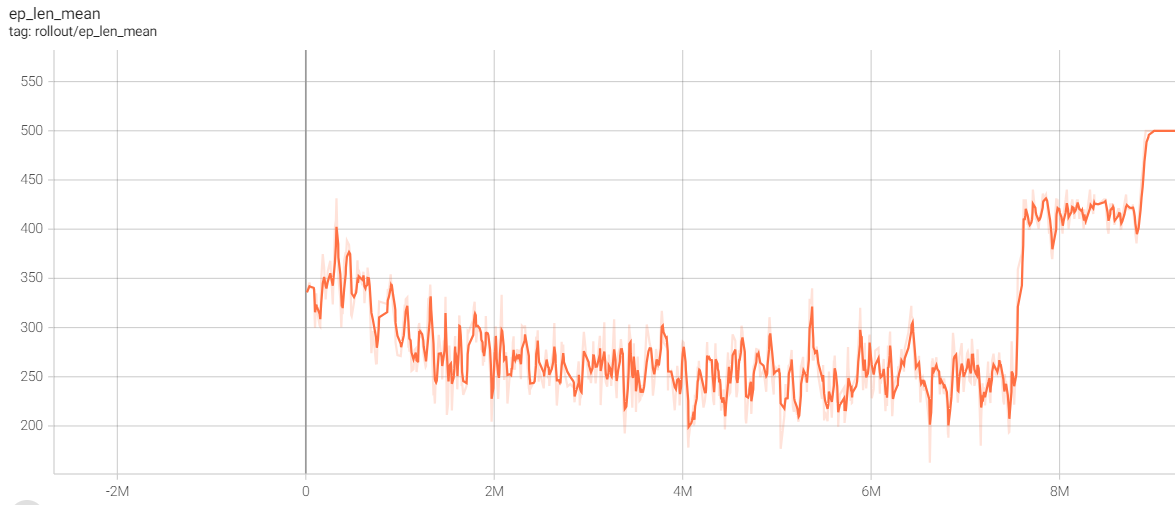

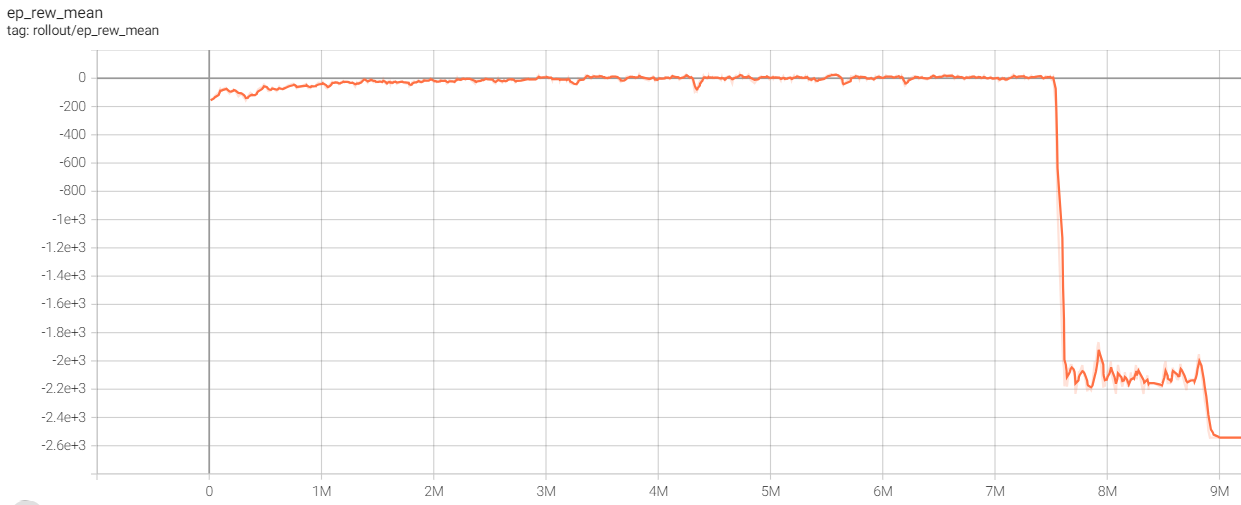

In [ ]:
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 6/E6-ELM.png"))
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 6/E6-ERM.png"))

### PPO2_0 Model Evaluation and Video Test - Middle of Training

In [ ]:
print("=" * 20 + "Evaluating Middle of Training Model PPO2_0" + "=" * 20)
print()
evaluate(env, PPO2_0_mid, 100)

print("=" * 20 + "Video Test Middle of Training Model PPO2_0" + "=" * 20)
print()
embed_mp4(video_test2(env, PPO2_0_mid))

====================Evaluating Middle of Training Model PPO2_0====================



100%|██████████| 100/100 [01:28<00:00,  1.14it/s]


Mean reward over 100 episodes: -217.19199999999975
Mean length per episode: 231.25
Number of environments solved: 56
====================Video Test Middle of Training Model PPO2_0====================



### PPO2_0 Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model PPO2_0" + "=" * 20)
print()
evaluate(env, PPO2_0_end, 100)

print("=" * 20 + "Video Test End of Training Model PPO2_0" + "=" * 20)
print()
embed_mp4(video_test2(env, PPO2_0_end))

====================Evaluating End of Training Model PPO2_0====================



100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


Mean reward over 100 episodes: -270.5539999999998
Mean length per episode: 278.36
Number of environments solved: 45
====================Video Test End of Training Model PPO2_0====================



## Experiment 7: PPO No Reward Shaping

### Custom Environment

In [ ]:
class CustomSokobanNoReward(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)
        obs = self.render()
        self.observation_space = spaces.Box(0, 255, obs.shape, obs.dtype)

    def reset(self):
        obs = super().reset()

        self.current_room_state = self.room_state.copy()

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        # self.next_room_state = self.room_state.copy()

        # if not done:
        #     reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        # self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.25


class CustomSokobanSlightReward(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)
        obs = self.render()
        self.observation_space = spaces.Box(0, 255, obs.shape, obs.dtype)

    def reset(self):
        obs = super().reset()

        self.current_room_state = self.room_state.copy()

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        # self.next_room_state = self.room_state.copy()

        # if not done:
        #     reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        # self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.25



### Train and Evaluate Model
We will use the same training code as in experiment 6, only with no/little rewards shaping during training. The full code can be found here: <br>
https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission/tree/main/Ex2/Experiment%206 <br>
As explained in the report we are training the best model form experiment 6.

In [ ]:
env = CustomSokobanNoReward()


env4_mid = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 7/models/env4_mid.zip");
env4_end = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 7/models/env4_end.zip");

env4_mid.set_env(env);
env4_end.set_env(env);

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### During Training Logs

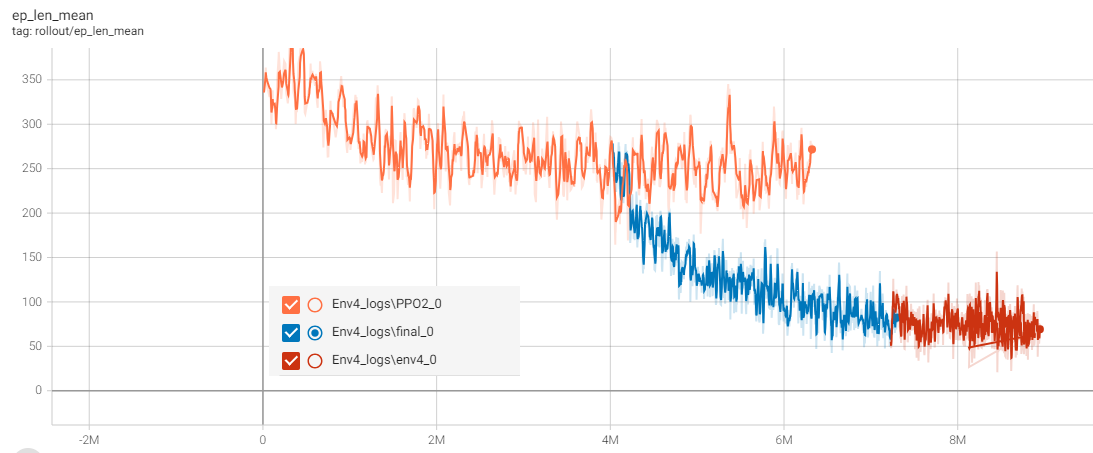

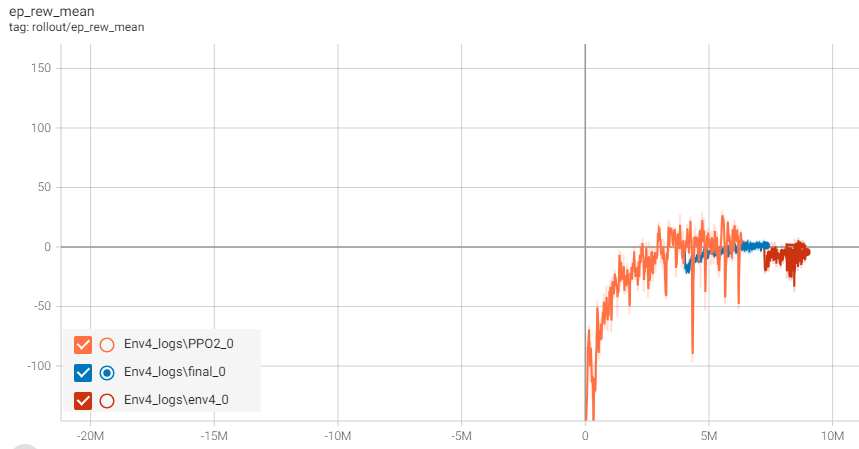

In [ ]:
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 7/E7-ELM.png"))
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex2/Experiment 7/E7-ERM.png"))

### env4 Model Evaluation and Video Test - Middle of Training

In [ ]:
print("=" * 20 + "Evaluating Middle of Training Model env4" + "=" * 20)
print()
evaluate(env, env4_mid, 100)

print("=" * 20 + "Video Test Middle of Training Model env4" + "=" * 20)
print()
embed_mp4(video_test2(env, env4_mid))

====================Evaluating Middle of Training Model env4====================



100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Mean reward over 100 episodes: 1.152999999999935
Mean length per episode: 81.97
Number of environments solved: 85
====================Video Test Middle of Training Model env4====================



### env4 Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model env4" + "=" * 20)
print()
evaluate(env, env4_end, 100)

print("=" * 20 + "Video Test End of Training Model env4" + "=" * 20)
print()
embed_mp4(video_test2(env, env4_end))

====================Evaluating End of Training Model env4====================



100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Mean reward over 100 episodes: 4.451999999999954
Mean length per episode: 55.58
Number of environments solved: 91
====================Video Test End of Training Model env4====================



## Experiment 8: Using Ex3 Model For Ex2

### Custom Environment

In [ ]:
class CustomSokobanNoReward(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)
        obs = self.render()
        self.observation_space = spaces.Box(0, 255, obs.shape, obs.dtype)

    def reset(self):
        obs = super().reset()

        self.current_room_state = self.room_state.copy()

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        # self.next_room_state = self.room_state.copy()

        # if not done:
        #     reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        # self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.25


class CustomSokobanSlightReward(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)
        obs = self.render()
        self.observation_space = spaces.Box(0, 255, obs.shape, obs.dtype)

    def reset(self):
        obs = super().reset()

        self.current_room_state = self.room_state.copy()

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        # self.next_room_state = self.room_state.copy()

        # if not done:
        #     reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        # self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.25



### Train and Evaluate Model
We have used the same model as in Ex3 Experiment 2, which has been trained on Ex3 for quiet some time.

In [ ]:
env = CustomSokobanNoReward()


env5_mid = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 2/models/env5_mid.zip");
env5_end = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 2/models/env5_end.zip");

env5_mid.set_env(env);
env5_end.set_env(env);

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### During Training Logs

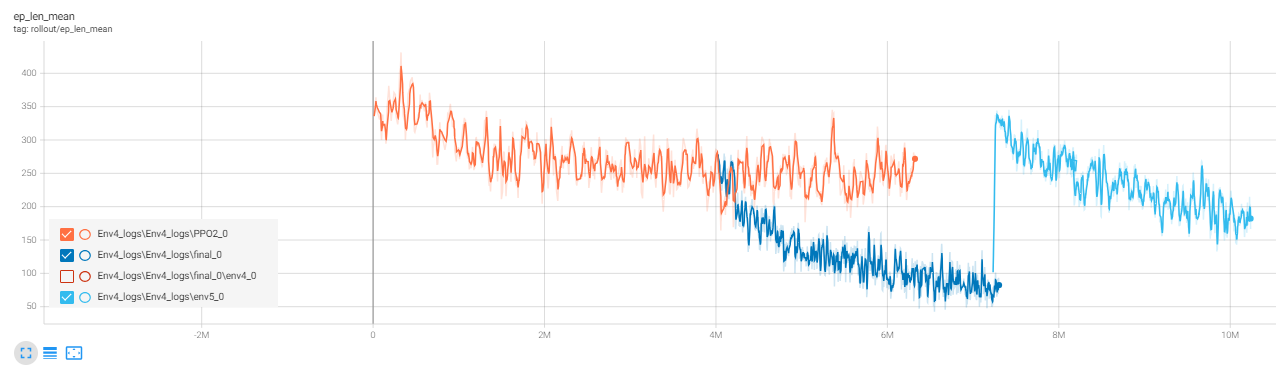

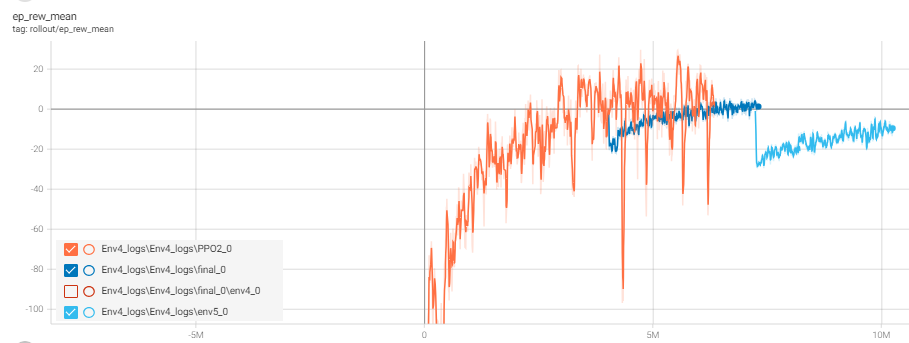

In [ ]:
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 2/Ex3v2-ELM.png"))
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 2/Ex3v2-ERM.png"))

### env5 Model Evaluation and Video Test - Middle of Training

In [ ]:
print("=" * 20 + "Evaluating Middle of Training Model env5" + "=" * 20)
print()
evaluate(env, env5_mid, 100)

print("=" * 20 + "Video Test Middle of Training Model env4" + "=" * 20)
print()
embed_mp4(video_test2(env, env5_mid))

====================Evaluating Middle of Training Model env5====================



100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Mean reward over 100 episodes: -3.5290000000000963
Mean length per episode: 122.19
Number of environments solved: 79
====================Video Test Middle of Training Model env4====================



### env5 Model Evaluation and Video Test - End of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model env5" + "=" * 20)
print()
evaluate(env, env5_end, 100)

print("=" * 20 + "Video Test End of Training Model env5" + "=" * 20)
print()
embed_mp4(video_test2(env, env5_end))

====================Evaluating End of Training Model env5====================



100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Mean reward over 100 episodes: -0.766000000000076
Mean length per episode: 98.96
Number of environments solved: 83
====================Video Test End of Training Model env5====================



# EX3 - PUSH & PULL - TWO BOXES
---

In [ ]:
#=============== DO NOT DELETE ===============
sok_3 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=2 ,max_steps=500)
# ============================================

## Experiment 1: PPO With Reward Shaping

### Custom Envirnment
A custom environment that

In [ ]:
class CustomSokobanEx3(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=2, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)
        self.current_room_state = self.room_state.copy()
        self._states = self.get_states(self.current_room_state)
        obs = self.render()
        self.observation_space = spaces.Box(0, 255, obs.shape, obs.dtype)

    def reset(self):
        obs = super().reset()
        self.current_room_state = self.room_state.copy()
        self._states = self.get_states(self.current_room_state)
        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)
        self.next_room_state = self.room_state.copy()

        if not done:
            reward += self.reward_shaping(self.current_room_state, self.next_room_state, self._states)

        self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)

    def reward_shaping(self, current_room_state, next_room_state, _states):
        change_reward = self.box2target_change_reward(current_room_state, next_room_state, _states)
        return change_reward

    def get_positions(self, room_state):
        targets = [tuple(np.argwhere(room_state == 2)[i]) for i in range(2)]
        return targets

    def get_distances(self, room_state, target):
        return self.get_distances_for_target(room_state, target)

    def reward_shaping(self, current_room_state, next_room_state, _states):
        if np.array_equal(current_room_state, next_room_state):
            return -2.0

        targets = self.get_positions(current_room_state)
        distances0 = self.get_distances(current_room_state, targets[0])
        distances1 = self.get_distances(current_room_state, targets[1])
        common_distances = np.minimum(distances0, distances1)

        relevant_distances = common_distances

        if current_room_state[targets[0]] == 3:
            relevant_distances = distances1
        elif current_room_state[targets[1]] == 3:
            relevant_distances = distances0

        t2b = self.calc_distances(current_room_state, relevant_distances)
        n_t2b = self.calc_distances(next_room_state, relevant_distances)
        change_reward = 2.0 if n_t2b < t2b else (-2.0 if n_t2b > t2b else 0.0)

        return change_reward

    def get_states(self, current_room_state):
        targets = self.get_positions(current_room_state)
        distances0 = self.get_distances(current_room_state, targets[0])
        distances1 = self.get_distances(current_room_state, targets[1])
        common_distances = np.minimum(distances0, distances1)

        states = {
            'target0': targets[0],
            'target1': targets[1],
            'distances0': distances0,
            'distances1': distances1,
            'common_distances': common_distances
        }
        return states

    def get_distances(self, room_state, target):
        distances = np.zeros(shape=room_state.shape)
        visited_cells = set()
        cell_queue = deque()

        visited_cells.add(target)
        cell_queue.appendleft(target)

        while len(cell_queue) != 0:
            cell = cell_queue.pop()
            distance = distances[cell[0]][cell[1]]
            for x,y in ((1,0), (-1,-0), (0,1), (0,-1)):
                next_cell_x, next_cell_y = cell[0]+x, cell[1]+y
                if room_state[next_cell_x][next_cell_y] != 0 and not (next_cell_x, next_cell_y) in visited_cells:
                    distances[next_cell_x][next_cell_y] = distance + 1
                    visited_cells.add((next_cell_x, next_cell_y))
                    cell_queue.appendleft((next_cell_x, next_cell_y))

        return distances

    def calc_distances(self, room_state, distances_to_target):
        boxes = [tuple(np.argwhere(room_state == 4)[i]) for i in range(2)]
        if len(boxes) == 2:
            return distances_to_target[boxes[0]] + distances_to_target[boxes[1]]
        return distances_to_target[boxes[0]]

### Train and Evaluate Model
We will use the same training code as in experiment 6, with the reward shaping described above. The full code can be found here:
https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission/tree/main/Ex3
During the training we hvae try to reduce the max number of steps, which explains the great drop in Episode Mean Length.

In [ ]:
env = CustomSokobanNoRewardEX3()


PPO3vX_0_mid = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 1/models/PPO3vX_0_mid.zip");
PPO3vX_0_end = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 1/models/PPO3vX_0_end.zip");

PPO3vX_0_mid.set_env(env);
PPO3vX_0_end.set_env(env);

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


### During Training Logs

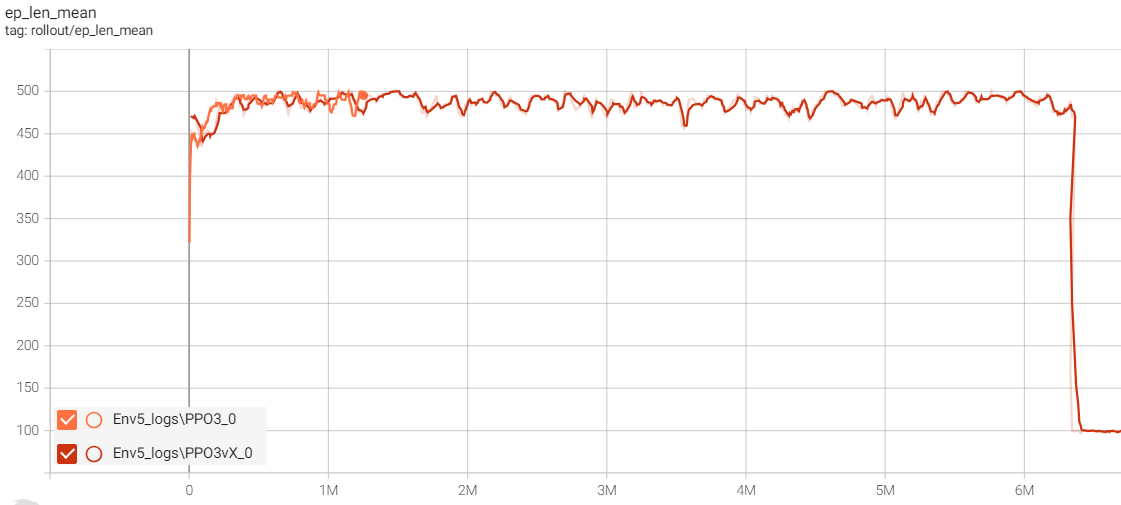

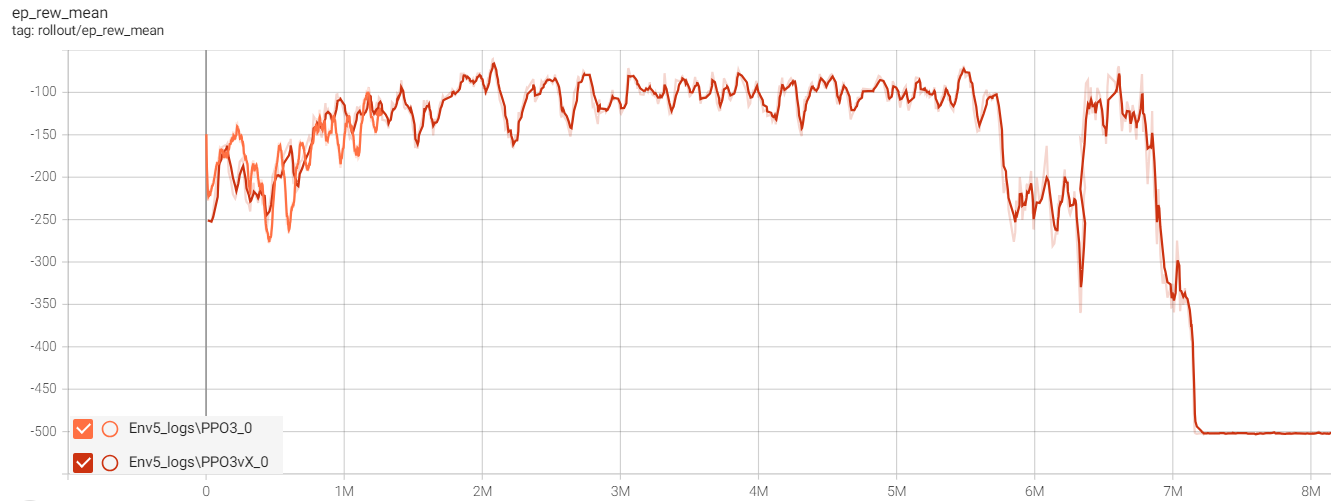

In [ ]:
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 1/EX3-ELM.png"))
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 1/EX3-ERM.png"))

### PPO3vX Model Evaluation and Video Test - Middle of Training

In [ ]:
print("=" * 20 + "Evaluating Middle of Training Model PPO3vX_0" + "=" * 20)
print()
evaluate(env, PPO3vX_0_mid, 100)

print("=" * 20 + "Evaluating Middle of Training Model PPO3vX_0" * 20)
print()
embed_mp4(video_test2(env, PPO3vX_0_mid))

====================Evaluating Middle of Training Model PPO3vX_0====================



  8%|▊         | 8/100 [00:15<02:56,  1.92s/it]

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .


100%|██████████| 100/100 [03:10<00:00,  1.91s/it]
/usr/local/lib/python3.10/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Mean reward over 100 episodes: -47.08200000000037
Mean length per episode: 477.92
Number of environments solved: 5
====================Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training Model PPO3vX_0Evaluating Middle of Training

### PPO3vX Model Evaluation and Video Test - Middle of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model PPO3vX_0" + "=" * 20)
print()
evaluate(env, PPO3vX_0_end, 100)

print("=" * 20 + "Evaluating End of Training Model PPO3vX_0" + "=" * 20)
print()
embed_mp4(video_test2(env, PPO3vX_0_end))

====================Evaluating End of Training Model PPO3vX_0====================



 42%|████▏     | 42/100 [01:22<01:51,  1.93s/it]

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .


100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Mean reward over 100 episodes: -50.00000000000036
Mean length per episode: 500.0
Number of environments solved: 0
====================Evaluating End of Training Model PPO3vX_0====================



## Experiment 2: PPO With Best Performing Model From Ex2

### Custom Environment

In [ ]:
class CustomSokobanNoRewardEX3(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=2, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)
        obs = self.render()
        self.observation_space = spaces.Box(0, 255, obs.shape, obs.dtype)

    def reset(self, second_player=False, render_mode="rgb_array"):
        obs = super().reset(second_player=False, render_mode="rgb_array")

        self.current_room_state = self.room_state.copy()

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        # self.next_room_state = self.room_state.copy()

        # if not done:
        #     reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        # self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.25


class CustomSokobanSlightRewardEX3(PushAndPullSokobanEnv):
    def __init__(self, dim_room=(7, 7), num_boxes=1, max_steps=500):
        super().__init__(dim_room=dim_room, num_boxes=num_boxes, max_steps=max_steps)
        obs = self.render()
        self.observation_space = spaces.Box(0, 255, obs.shape, obs.dtype)

    def reset(self, second_player=False, render_mode="rgn_array"):
        obs = super().reset(second_player=False, render_mode="rgn_array")

        self.current_room_state = self.room_state.copy()

        return obs

    def step(self, action):
        next_state, reward, done, info = super().step(action)

        self.next_room_state = self.room_state.copy()

        if not done:
            reward += self.reward_shaping(self.current_room_state, self.next_room_state, self.distances)

        self.current_room_state = self.next_room_state.copy()

        return next_state, reward, done, info

    def render(self, mode='rgb_array'):
        return super().render(mode=mode)


    def reward_shaping(self, current_room_state, next_room_state):

        # If there is no change in the room state we are
        if np.array_equal(current_room_state, next_room_state): return -0.25

### Train and Evaluate Model
We will use the same training code as in experiment 1 of Ex1, we will let the best model in Ex2 to train and give it no paricular reward shaping. The full code can be found here:
https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission/tree/main/Ex3
During the training we have introduced a slight reward for staying in place.

In [ ]:
env = CustomSokobanNoRewardEX3()


env5_mid = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 2/models/env5_mid.zip");
env5_end = PPO.load("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 2/models/env5_end.zip");

env5_mid.set_env(env);
env5_end.set_env(env);

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


### During Training Logs

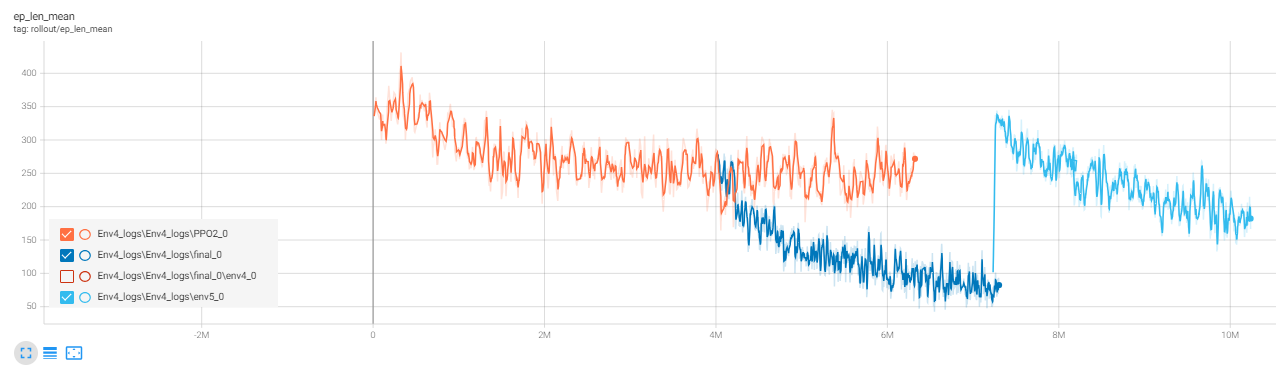

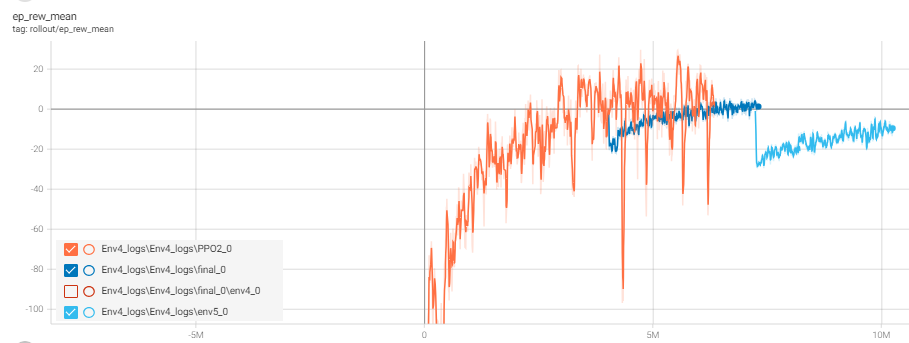

In [ ]:
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 2/Ex3v2-ELM.png"))
display(Image("/content/Intro_to_Reinforcement-Learning-Final_Submission/Ex3/Experiment 2/Ex3v2-ERM.png"))

### env5 Model Evaluation and Video Test - Middle of Training

In [ ]:
print("=" * 20 + "Evaluating Middle of Training Model env5" + "=" * 20)
print()
evaluate(env, env5_mid, 100)

print("=" * 20 + "Evaluating Middle of Training Model env5" * 20)
print()
embed_mp4(video_test2(env, env5_mid))

====================Evaluating Middle of Training Model env5====================



100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Mean reward over 100 episodes: -12.352000000000157
Mean length per episode: 203.32
Number of environments solved: 65
====================Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5Evaluating Middle of Training Model env5



env5 Model Evaluation and Video Test - Middle of Training

In [ ]:
print("=" * 20 + "Evaluating End of Training Model env5" + "=" * 20)
print()
evaluate(env, env5_end, 100)

print("=" * 20 + "Evaluating End of Training Model env5" + "=" * 20)
print()
embed_mp4(video_test2(env, env5_end))

====================Evaluating End of Training Model env5====================



 55%|█████▌    | 55/100 [00:27<00:10,  4.50it/s]

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Mean reward over 100 episodes: -1.7020000000000806
Mean length per episode: 117.42
Number of environments solved: 83
====================Evaluating End of Training Model env5====================

